In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [6]:
df = pd.read_pickle('English_Headlines_EngFeatures.pkl')
df.head()

,Statement,Rating,cleaned,cleaned tokenized,tokens,statement length,word count,sentence count,unique words,lexical richness,...,numerical%,sexual anatomy / sexual acts,bodily fluids / excrement,sexual orientation / gender,racial / ethnic slurs,animal references,internet slang,profanity_level,bigrams,trigrams
0,Changing our clocks is a health hazard. Just a...,1,changing clocks health hazard ask sleep doctor,"[changing, clock, health, hazard, ., ask, slee...","[Changing, our, clocks, is, a, health, hazard,...",13,46,2,11,40.32,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012298,"[changing clocks, clocks health, health hazard...","[changing clocks health, clocks health hazard,..."
1,How the Alec Baldwin fatal film set shooting u...,1,alec baldwin fatal film set shooting unfolded,"[alec, baldwin, fatal, film, set, shooting, un...","[How, the, Alec, Baldwin, fatal, film, set, sh...",9,45,1,9,9.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.025994,"[alec baldwin, baldwin fatal, fatal film, film...","[alec baldwin fatal, baldwin fatal film, fatal..."
2,A 90-year-old tortoise named Mr. Pickles just ...,1,90 year old tortoise named mr pickles became f...,"[90-year-old, tortoise, named, mr., pickle, be...","[A, 90-year-old, tortoise, named, Mr., Pickles...",19,62,2,17,35.84,...,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.031957,"[90 year, year old, old tortoise, tortoise nam...","[90 year old, year old tortoise, old tortoise ..."
3,Alabama governor ousts a top education officia...,1,alabama governor ousts top education official ...,"[alabama, governor, ousts, top, education, off...","[Alabama, governor, ousts, a, top, education, ...",17,69,1,14,63.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010403,"[alabama governor, governor ousts, ousts top, ...","[alabama governor ousts, governor ousts top, o..."
4,"2 people are dead, 20 missing, as a migrant bo...",1,2 people dead 20 missing migrant boat sinks co...,"[2, people, dead, ,, 20, missing, ,, migrant, ...","[2, people, are, dead, ,, 20, missing, ,, as, ...",18,57,1,16,14.00,...,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.065102,"[2 people, people dead, dead 20, 20 missing, m...","[2 people dead, people dead 20, dead 20 missin..."


In [10]:
sentences = df['Statement'].values
y = df['Rating'].values

In [11]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=49)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [13]:
input_dim = X_train.shape[1]

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)

In [17]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=45)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [18]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
X_train.shape

(5238, 100)

In [20]:
from keras.models import Sequential
from keras import layers
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [21]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [22]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    'glove/glove.6B.100d.txt',
    tokenizer.word_index, embedding_dim)

In [23]:
vocab_size = len(tokenizer.word_index) + 1

In [24]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1377000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,442,429
Trainable params: 1,442,429
Non-trainable params: 0
____________________________________________

Epoch 1/10
524/524 [==============================] - 8s 7ms/step - loss: 0.4921 - accuracy: 0.7425 - val_loss: 0.3549 - val_accuracy: 0.8313
Epoch 2/10
524/524 [==============================] - 3s 7ms/step - loss: 0.1743 - accuracy: 0.9343 - val_loss: 0.3950 - val_accuracy: 0.8359
Epoch 3/10
524/524 [==============================] - 3s 7ms/step - loss: 0.0365 - accuracy: 0.9901 - val_loss: 0.5236 - val_accuracy: 0.8344
Epoch 4/10
524/524 [==============================] - 3s 7ms/step - loss: 0.0086 - accuracy: 0.9983 - val_loss: 0.6102 - val_accuracy: 0.8382
Epoch 5/10
524/524 [==============================] - 4s 7ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.6781 - val_accuracy: 0.8351
Epoch 6/10
524/524 [==============================] - 4s 8ms/step - loss: 8.7523e-04 - accuracy: 0.9998 - val_loss: 0.7164 - val_accuracy: 0.8389
Epoch 7/10
524/524 [==============================] - 4s 7ms/step - loss: 6.5467e-04 - accuracy: 0.9998 - val_loss: 0.7514 - val_accuracy: 0.827

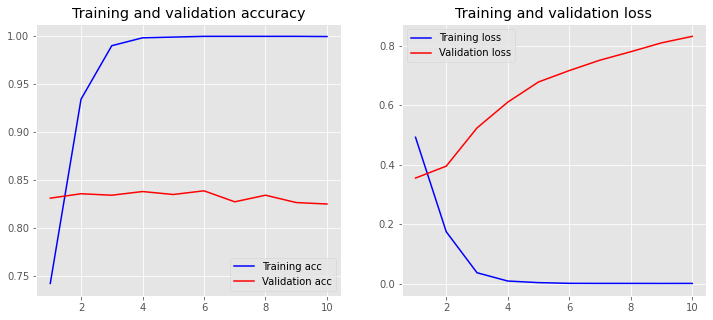

In [25]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                116210    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 116,221
Trainable params: 116,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/100


c:\Users\cvaal\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


164/164 [==============================] - 3s 7ms/step - loss: 0.6250 - accuracy: 0.7289 - val_loss: 0.5273 - val_accuracy: 0.8160
Epoch 2/100
164/164 [==============================] - 1s 6ms/step - loss: 0.3986 - accuracy: 0.8921 - val_loss: 0.4124 - val_accuracy: 0.8321
Epoch 3/100
164/164 [==============================] - 1s 6ms/step - loss: 0.2470 - accuracy: 0.9414 - val_loss: 0.3695 - val_accuracy: 0.8405
Epoch 4/100
164/164 [==============================] - 1s 6ms/step - loss: 0.1617 - accuracy: 0.9704 - val_loss: 0.3560 - val_accuracy: 0.8420
Epoch 5/100
164/164 [==============================] - 1s 7ms/step - loss: 0.1108 - accuracy: 0.9845 - val_loss: 0.3569 - val_accuracy: 0.8382
Epoch 6/100
164/164 [==============================] - 1s 6ms/step - loss: 0.0782 - accuracy: 0.9914 - val_loss: 0.3625 - val_accuracy: 0.8359
Epoch 7/100
164/164 [==============================] - 1s 6ms/step - loss: 0.0568 - accuracy: 0.9952 - val_loss: 0.3713 - val_accuracy: 0.8351
Epoch 8/100

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print(f"Training Accuracy: {accuracy}")
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Testing Accuracy:  {accuracy}")

Training Accuracy: 0.9998090863227844
Testing Accuracy:  0.8122137188911438


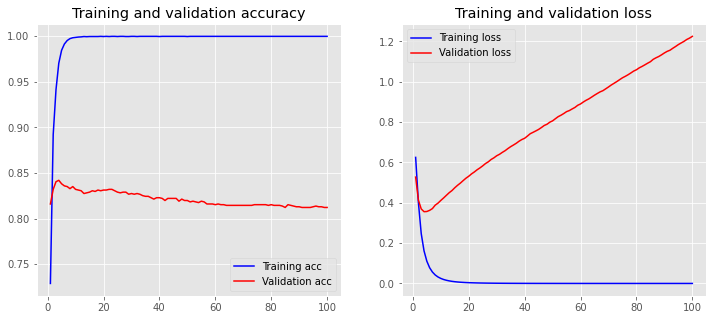

In [ ]:
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
print(sentences_train[2])

Church of England Declares ‘Jesus Is Non-Binary’


In [ ]:
print(X_train[2])

[484, 4, 932, 506, 10, 1112]


In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           688500    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 689,021
Trainable params: 689,021
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
524/524 [==============================] - 5s 8ms/step - loss: 0.6134 - accuracy: 0.7003 - val_loss: 0.4681 - val_accuracy: 0.8023
Epoch 2/20
524/524 [==============================] - 4s 8ms/step - loss: 0.3042 - accuracy: 0.8881 - val_loss: 0.3346 - val_accuracy: 0.8534
Epoch 3/20
524/524 [==============================] - 4s 8ms/step - loss: 0.1335 - accuracy: 0.9586 - val_loss: 0.3388 - val_accuracy: 0.8603
Epoch 4/20
524/524 [==============================] - 4s 8ms/step - loss: 0.0532 - accuracy: 0.9878 - val_loss: 0.3775 - val_accuracy: 0.8466
Epoch 5/20
524/524 [==============================] - 4s 8ms/step - loss: 0.0196 - accuracy: 0.9981 - val_loss: 0.4128 - val_accuracy: 0.8389
Epoch 6/20
524/524 [==============================] - 4s 9ms/step - loss: 0.0085 - accuracy: 0.9994 - val_loss: 0.4433 - val_accuracy: 0.8389
Epoch 7/20
524/524 [==============================] - 5s 9ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.4853 - val_accuracy: 0.8435
Epoch 

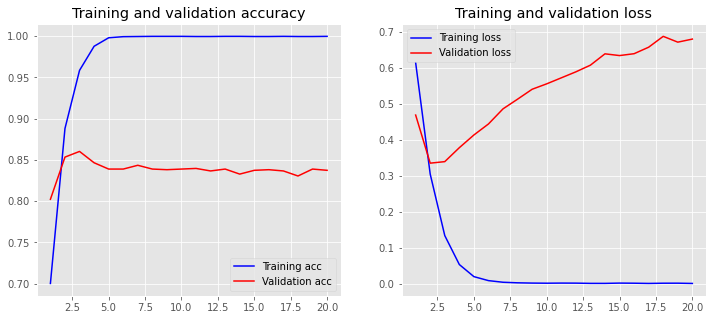

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1377000   
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,378,021
Trainable params: 1,378,021
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
524/524 [==============================] - 4s 6ms/step - loss: 0.6752 - accuracy: 0.5836 - val_loss: 0.6106 - val_accuracy: 0.7252
Epoch 2/50
524/524 [==============================] - 3s 6ms/step - loss: 0.5121 - accuracy: 0.7591 - val_loss: 0.4503 - val_accuracy: 0.7863
Epoch 3/50
524/524 [==============================] - 3s 6ms/step - loss: 0.3502 - accuracy: 0.8511 - val_loss: 0.4069 - val_accuracy: 0.8038
Epoch 4/50
524/524 [==============================] - 3s 6ms/step - loss: 0.2377 - accuracy: 0.9049 - val_loss: 0.3776 - val_accuracy: 0.8252
Epoch 5/50
524/524 [==============================] - 4s 7ms/step - loss: 0.1546 - accuracy: 0.9488 - val_loss: 0.3853 - val_accuracy: 0.8313
Epoch 6/50
524/524 [==============================] - 4s 7ms/step - loss: 0.0933 - accuracy: 0.9727 - val_loss: 0.4012 - val_accuracy: 0.8382
Epoch 7/50
524/524 [==============================] - 3s 7ms/step - loss: 0.0561 - accuracy: 0.9863 - val_loss: 0.4263 - val_accuracy: 0.8382
Epoch 

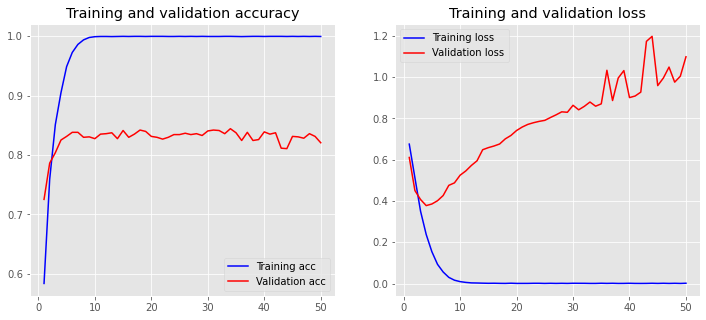

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()

In [39]:
import re
pattern = r"^\s*(?:...){0,2}(XXX|OOO)|^\s*(O|X)..\2..\2..|^\s*.(O|X)..\3..\3.|^\s*..(O|X)..\4..\4|^\s*(O|X)...\5...\5|^\s*..(O|X).\6.\6.."



In [117]:
pat = 'XOxXOxOXx'

In [118]:
for i in

SyntaxError: invalid syntax (Temp/ipykernel_3436/4292019277.py, line 1)

In [119]:
for i in pat:
    if i == 'x':
        pat = pat.replace(i, 'O', 1)
        print(pat)

XOOXOxOXx
XOOXOOOXx
XOOXOOOXO


In [53]:
import re

winning = ['OOOxxxxxx',
'XOXXOOOXX',
'xxxxxxOOO',
'OxxOxxOxx',
'xOxxOxxOx',
'xxOxxOxxO',
'OxxxOxxxO',
'xxOxOxOxx']

for i in winning:
    if re.search(pattern, i):
        print('Yes')
    else:
        print('No')


Yes
No
Yes
Yes
Yes
Yes
Yes
Yes


In [115]:
pat = 'XOxXOxOXx'
grid = list(zip(*[iter(pat)]*3))
grid = [list(tup) for tup in grid]

In [111]:
print(grid)

[['X', 'O', 'X'], ['X', 'O', 'X'], ['O', 'X', 'X']]


In [112]:
''.join(item for innerlist in pat for item in innerlist)

'XOXXOXOXX'

In [116]:
'x' not in pat

False